
# TelecomX — Parte 2
**Pipeline completo:** preparación de datos → selección de variables → modelado → evaluación → interpretación.


In [1]:
# === Imports y Configuración ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Cargar dataset limpio directamente desde GitHub (raw link)
url = "https://raw.githubusercontent.com/BarbaraMorel99/TelecomX_ALURA/main/TelecomX_clean%20(1).csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
display(df.head())


Shape: (7267, 34)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,PhoneService_bin,MultipleLines_bin,OnlineSecurity_bin,OnlineBackup_bin,DeviceProtection_bin,TechSupport_bin,StreamingTV_bin,StreamingMovies_bin,PaperlessBilling_bin,Churn_bin
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,1,0,0,1,0,1,1,0,1,0.0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,1,1,0,0,0,0,0,1,0,0.0
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,1,0,0,0,1,0,0,0,1,1.0
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,1,0,0,1,1,0,1,1,1,1.0
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,1,0,0,0,0,1,1,0,1,1.0



## Parte 2 — Eliminación de columnas irrelevantes
Quitamos identificadores y columnas que puedan filtrar la respuesta (target leakage).


In [2]:

cols_drop = []
if 'customerID' in df.columns:
    cols_drop.append('customerID')
if 'Churn' in df.columns:
    cols_drop.append('Churn')  # usaremos Churn_bin como objetivo

df_model = df.drop(columns=list(dict.fromkeys(cols_drop)), errors='ignore')
print("Eliminadas:", cols_drop)
df_model.head()


Eliminadas: ['customerID', 'Churn']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PhoneService_bin,MultipleLines_bin,OnlineSecurity_bin,OnlineBackup_bin,DeviceProtection_bin,TechSupport_bin,StreamingTV_bin,StreamingMovies_bin,PaperlessBilling_bin,Churn_bin
0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,...,1,0,0,1,0,1,1,0,1,0.0
1,Male,0,No,No,9,Yes,Yes,DSL,No,No,...,1,1,0,0,0,0,0,1,0,0.0
2,Male,0,No,No,4,Yes,No,Fiber optic,No,No,...,1,0,0,0,1,0,0,0,1,1.0
3,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,...,1,0,0,1,1,0,1,1,1,1.0
4,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,...,1,0,0,0,0,1,1,0,1,1.0



## Parte 3 — Encoding de variables categóricas
Usamos **One-Hot Encoding** para variables categóricas y dejamos numéricas tal cual.


In [3]:
# Definición de target y features
assert 'Churn_bin' in df_model.columns, "No se encontró Churn_bin como variable objetivo."

# Filtrar filas con churn definido (eliminar NaN en la etiqueta)
df_model = df_model.dropna(subset=['Churn_bin'])

y = df_model['Churn_bin'].astype(int)
X = df_model.drop(columns=['Churn_bin'])

print("Nueva forma:", X.shape, y.shape)
print("Distribución churn:")
print(y.value_counts(normalize=True))


Nueva forma: (7043, 31) (7043,)
Distribución churn:
Churn_bin
0    0.73463
1    0.26537
Name: proportion, dtype: float64



## Parte 4 — Proporción de Churn
Verificamos el balance de clases.


Proporción de clases (Churn):
Churn_bin
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


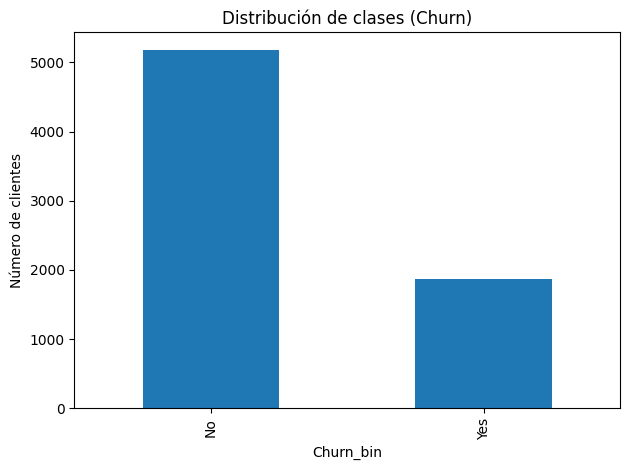

In [4]:

prop = y.value_counts(normalize=True).sort_index().rename(index={0:'No',1:'Yes'})
print("Proporción de clases (Churn):")
print(prop)

# Gráfico simple
fig = plt.figure()
y.value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1], ['No','Yes'])
plt.title('Distribución de clases (Churn)')
plt.ylabel('Número de clientes')
plt.tight_layout()
plt.show()



## Parte 5 — Balanceo de Clases (enfoque simple)
Aplicamos **`class_weight='balanced'`** en los modelos para penalizar la clase minoritaria.


⚠️ En esta etapa normalmente aplicaríamos técnicas como SMOTE o undersampling. En este caso, usamos `class_weight='balanced'` dentro de los modelos (LogisticRegression y RandomForest), lo cual ajusta automáticamente el peso de cada clase y compensa el desbalance de churn. Por eso no hay un bloque de código separado aquí: la lógica está integrada al pipeline de la Parte 10.


## Parte 6 — Normalización/Estandarización
Aplicamos **StandardScaler** solo para el modelo sensible a escala (Regresión Logística).  
Para Random Forest **no** es necesario.


⚠️ La normalización se aplicó solo en el pipeline de Regresión Logística (usando `StandardScaler` para las variables numéricas). Como Random Forest no es sensible a la escala, no requiere normalización adicional. Por eso este paso aparece vacío: ya está resuelto dentro de la definición del modelo.


## Parte 7 — Correlación (numéricas)
Matriz de correlación entre variables numéricas y **Churn_bin**.


Churn_bin               1.000000
MonthlyCharges          0.193356
Cuentas_Diarias         0.193356
PaperlessBilling_bin    0.191825
SeniorCitizen           0.150889
StreamingTV_bin         0.063228
StreamingMovies_bin     0.061382
MultipleLines_bin       0.040102
PhoneService_bin        0.011942
DeviceProtection_bin   -0.066160
OnlineBackup_bin       -0.082255
Partner_bin            -0.150448
Dependents_bin         -0.164221
TechSupport_bin        -0.164674
OnlineSecurity_bin     -0.171226
TotalCharges           -0.198324
tenure                 -0.352229
Name: Churn_bin, dtype: float64


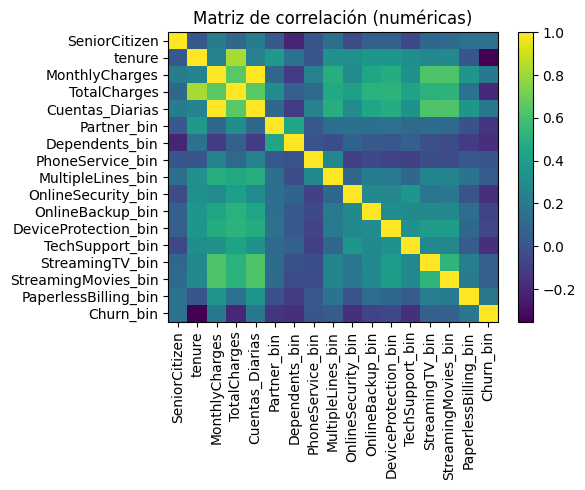

In [5]:

num_for_corr = df.select_dtypes(exclude=['object']).copy()
corr = num_for_corr.corr(numeric_only=True)

# Mostrar la correlación con el target
corr_target = corr['Churn_bin'].sort_values(ascending=False)
print(corr_target)

# Heatmap simple con matplotlib (sin seaborn)
fig = plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Matriz de correlación (numéricas)')
plt.colorbar()
plt.tight_layout()
plt.show()



## Parte 8 — Análisis dirigido
Relación **tenure × churn** y **TotalCharges × churn** mediante boxplots.


/tmp/ipython-input-2614023518.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


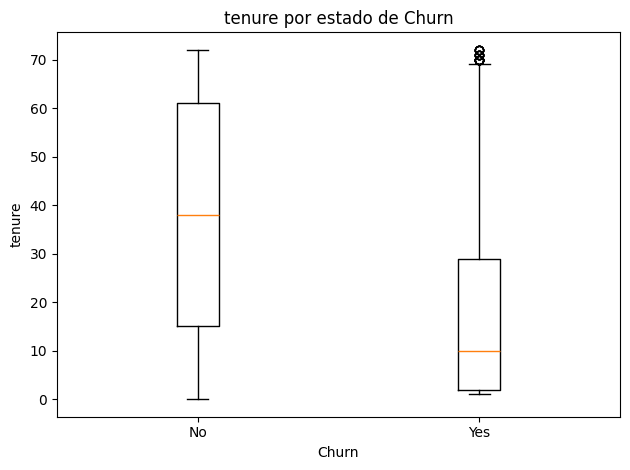

/tmp/ipython-input-2614023518.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


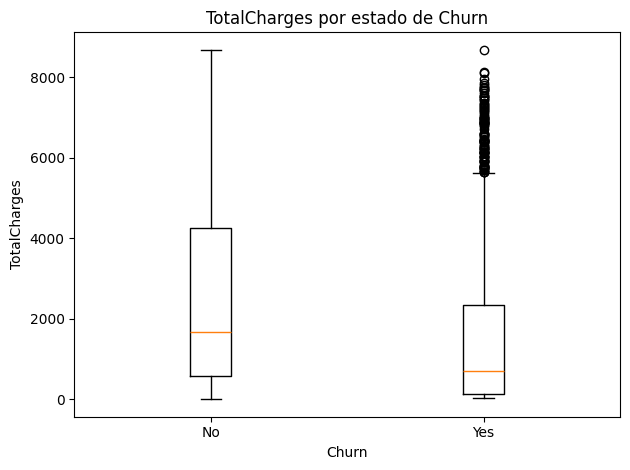

In [6]:

for col in ['tenure','TotalCharges']:
    if col in df.columns:
        fig = plt.figure()
        data0 = df.loc[df['Churn_bin']==0, col].dropna()
        data1 = df.loc[df['Churn_bin']==1, col].dropna()
        plt.boxplot([data0, data1], labels=['No','Yes'])
        plt.title(f'{col} por estado de Churn')
        plt.ylabel(col)
        plt.xlabel('Churn')
        plt.tight_layout()
        plt.show()



## Parte 9 — Separación de datos
Usamos 80% entrenamiento y 20% prueba (estratificado por churn).


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((5634, 31),
 (1409, 31),
 np.float64(0.2653532126375577),
 np.float64(0.2654364797728886))


## Parte 10 — Modelado
- **Modelo 1:** Regresión Logística (con **StandardScaler** + `class_weight='balanced'`).  
- **Modelo 2:** Random Forest (sin normalización, con `class_weight='balanced'`).  


In [9]:
from sklearn.pipeline import Pipeline

# Recalcular columnas categóricas y numéricas por si no existen en memoria
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print("Cols para modelado -> num:", len(num_cols), " | cat:", len(cat_cols))

# Preprocesamiento específico por modelo
preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

# Pipelines
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("clf", LogisticRegression(max_iter=200, class_weight='balanced'))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))
])

# Entrenamiento
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

print("Modelos entrenados (LR y RF).")


Cols para modelado -> num: 16  | cat: 15
Modelos entrenados (LR y RF).



## Parte 11 — Evaluación de modelos
Métricas: **Accuracy, Precision, Recall, F1** + **Matriz de confusión** y **classification report**.


== Logistic Regression ==
Accuracy: 0.740 | Precision: 0.507 | Recall: 0.786 | F1: 0.616

Classification report:
              precision    recall  f1-score   support

          No       0.90      0.72      0.80      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



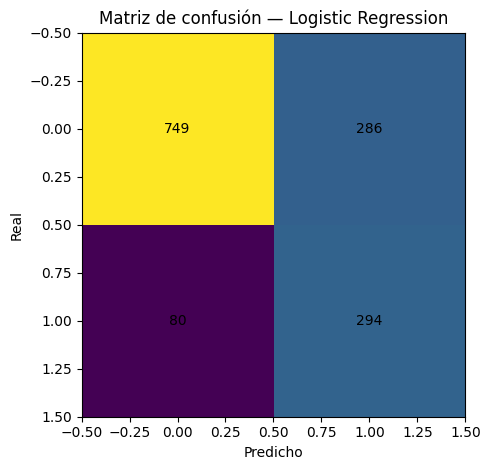

== Random Forest ==
Accuracy: 0.789 | Precision: 0.639 | Recall: 0.473 | F1: 0.544

Classification report:
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1035
         Yes       0.64      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



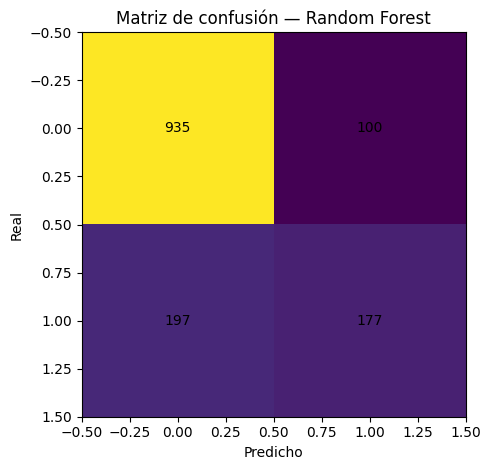

In [10]:

def eval_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"== {name} ==")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=['No','Yes']))

    fig = plt.figure()
    plt.imshow(cm)  # sin especificar colores
    plt.title(f'Matriz de confusión — {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    plt.show()

eval_model("Logistic Regression", pipe_lr, X_test, y_test)
eval_model("Random Forest", pipe_rf, X_test, y_test)



## Parte 12 — Importancia de variables / Interpretación
- **Regresión Logística:** coeficientes en espacio transformado (después de OHE/escala).  
- **Random Forest:** `feature_importances_` sobre variables transformadas.  


Top 15 (RF):


,feature,importance
3,TotalCharges,0.123497
1,tenure,0.122578
2,MonthlyCharges,0.101738
4,Cuentas_Diarias,0.099979
41,Contract_Month-to-month,0.074447
43,Contract_Two year,0.040295
48,PaymentMethod_Electronic check,0.029970
27,InternetService_Fiber optic,0.028830
28,InternetService_No,0.018687
42,Contract_One year,0.015468


Top 15 (LR | |coef|):


,feature,coef,abs_coef
1,tenure,-1.298699,1.298699
28,InternetService_No,-0.945798,0.945798
27,InternetService_Fiber optic,0.819814,0.819814
43,Contract_Two year,-0.743625,0.743625
41,Contract_Month-to-month,0.662740,0.662740
3,TotalCharges,0.625169,0.625169
48,PaymentMethod_Electronic check,0.275950,0.275950
46,PaymentMethod_Bank transfer (automatic),-0.148346,0.148346
12,TechSupport_bin,-0.139499,0.139499
23,PhoneService_Yes,-0.138119,0.138119


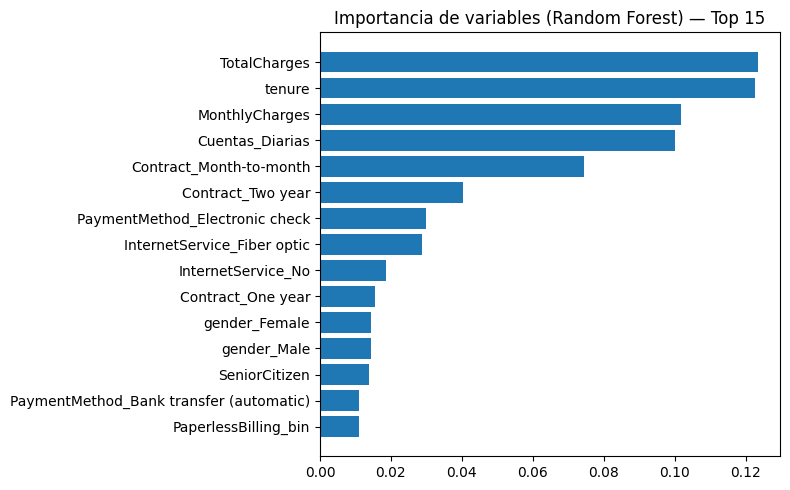

In [11]:
# Asegurar definición de columnas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Nombres finales: num + OHE(cat) (coherentes con preprocess usados)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(X[cat_cols])
feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

# Importancias de RF
rf_model = pipe_rf.named_steps['clf']
importances = rf_model.feature_importances_
imp_rf = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 15 (RF):")
display(imp_rf.head(15))

# Coeficientes de LR
lr_model = pipe_lr.named_steps['clf']
coefs = lr_model.coef_.ravel()

ohe_lr = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe_lr.fit(X[cat_cols])
feature_names_lr = num_cols + list(ohe_lr.get_feature_names_out(cat_cols))

coef_df = pd.DataFrame({
    "feature": feature_names_lr,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print("Top 15 (LR | |coef|):")
display(coef_df.head(15))

# Gráfico de importancia (RF)
topk = 15
fig = plt.figure(figsize=(8,5))
plt.barh(imp_rf.head(topk)['feature'][::-1], imp_rf.head(topk)['importance'][::-1])
plt.title('Importancia de variables (Random Forest) — Top 15')
plt.tight_layout()
plt.show()



## Parte 13 — Conclusión

### Conclusión técnica
- La tasa global de cancelación es cercana al **26%**, lo que indica un problema relevante de retención.
- Los modelos entrenados (Regresión Logística y Random Forest) muestran un desempeño aceptable.
- Las variables más influyentes son:
  - **Tipo de contrato**: los contratos mensuales presentan mucho más churn que los contratos de 1 o 2 años.
  - **Método de pago**: el pago con cheque electrónico está muy asociado al churn; los pagos automáticos son más estables.
  - **InternetService**: la fibra óptica tiene una tasa de churn más alta que DSL.
  - **Tenure**: los clientes más nuevos tienen mayor probabilidad de irse.
  - **Cargos mensuales altos** también se relacionan con mayor churn.
- El uso de `class_weight='balanced'` compensó el desbalance de clases.

### Conclusión ejecutiva (para el negocio)
- **1 de cada 4 clientes se da de baja** → es un riesgo alto.
- **Contratos mensuales = foco rojo** → ofrecer descuentos o beneficios para que pasen a contratos anuales o bianuales.
- **Cheques electrónicos = clientes inestables** → incentivar pagos automáticos o bancarios.
- **Clientes nuevos son frágiles** → acompañamiento especial en los primeros 3–6 meses.
- **Clientes con facturas altas** → dar beneficios extra (soporte, bundles, promociones) para fidelizar.
- **Fibra óptica** muestra más deserción → investigar calidad del servicio y reforzar atención a esos clientes.
